In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from scipy.optimize import curve_fit
from scipy import stats
from sklearn.decomposition import PCA
import random

LIST_PATH   = Path(r"C:\PHY199\list_file_9.txt")
MATRIX_PATH = Path(r"C:\PHY199\flux_matrix_9.txt")

rows = []
for ln in LIST_PATH.read_text().splitlines():
    if ln.strip():
        pieces = {k.strip(): v.strip() for k, v in
                  (kv.split(':',1) for kv in ln.split(','))}
        rows.append(pieces)

meta = (pd.DataFrame(rows)
          .rename(columns={'Spec1D File':'fname','Redshift':'z',
                           'lambda_min':'lam_min_obs','lambda_max':'lam_max_obs'})
          .astype({'z':float,'lam_min_obs':float,'lam_max_obs':float}))
meta['lam_min_rest'] = meta['lam_min_obs']/(1+meta['z'])
meta['lam_max_rest'] = meta['lam_max_obs']/(1+meta['z'])

flux_matrix = pd.read_csv(MATRIX_PATH, sep=' ', header=None).values
wavelengths = np.arange(3683, 5300.01, 0.3)

pca        = PCA(n_components=3)
scores     = pca.fit_transform(flux_matrix)
meta['PC3'] = scores[:,2]


In [ ]:
HBETA = 4862.68     # Å, Hβ rest-frame line center
WIN_HB = 12 
MIN_F_HB = 0.0 

def gauss_const(lmbda, A, mu, sigma, C):
    """Single Gaussian + constant continuum."""
    return C + A * np.exp(-(lmbda - mu)**2 / (2 * sigma**2))

# measure Hβ integrated flux for each spectrum
hb_records = []   # will store idx, flux_Hb, and fit params for plotting

for i, row in meta.iterrows():
    # make sure Hβ is inside the *rest-frame* coverage with a small buffer
    if not (row.lam_min_rest < HBETA - 20 and row.lam_max_rest > HBETA + 20):
        continue

    spec = flux_matrix[i, :]

    # pick pixels near Hβ
    msk = (wavelengths > HBETA - WIN_HB) & (wavelengths < HBETA + WIN_HB)
    x, y = wavelengths[msk], spec[msk]
    if x.size < 7:
        continue

    # initial guesses: (amplitude, center, width, continuum)
    p0 = [y.max() - y.min(), HBETA, 1.0, float(np.median(y))]

    try:
        popt, _ = curve_fit(gauss_const, x, y, p0=p0, maxfev=15000)
        A, mu, sigma, C = popt
        F_Hb = A * sigma * np.sqrt(2 * np.pi)  # integrated flux (area)
    except RuntimeError:
        continue

    if F_Hb <= MIN_F_HB:
        continue

    hb_records.append(dict(idx=i,
                           PC1=scores[i, 0],
                           PC2=scores[i, 1],
                           PC3=scores[i, 2],
                           flux_Hb=F_Hb,
                           p_Hb=popt))  # store fit params for plotting later

hb = pd.DataFrame(hb_records)
print(f"Measured Hβ for {len(hb)} spectra.")


C:\Users\user1\AppData\Local\Temp\ipykernel_36280\2170024048.py:31: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(gauss_const, x, y, p0=p0, maxfev=15000)


Measured Hβ for 1007 spectra.


In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

HBETA = 4862.68          # Å, Hβ rest wavelength
WIN_HB = 12              # half window size (Å) for fitting
SNR_MIN = 3.0            # minimum S/N cut for Hβ
MU_TOL = 3.0             # |mu_emission - HBETA| must be <= this (Å)

def hbeta_model(l, A_em, mu_em, sig_em, A_abs, sig_abs, m0, m1):

    emission   = A_em * np.exp(-(l - mu_em)**2 / (2 * sig_em**2))
    absorption = A_abs * np.exp(-(l - HBETA)**2 / (2 * sig_abs**2))
    continuum  = m0 + m1 * (l - HBETA)
    return continuum + emission - absorption

hb_rows = []

for i, row in meta.iterrows():
    # make sure Hβ is in rest-frame coverage (with a buffer)
    if not (row.lam_min_rest < HBETA - 20 and row.lam_max_rest > HBETA + 20):
        continue

    spec = flux_matrix[i, :]

    # pick a small window around Hβ
    msk = (wavelengths > HBETA - WIN_HB) & (wavelengths < HBETA + WIN_HB)
    x = wavelengths[msk]
    y = spec[msk]
    if x.size < 12:   # too few pixels to fit
        continue

    # crude initial guesses
    m0_0 = float(np.median(y))
    m1_0 = float((y[-1] - y[0]) / (x[-1] - x[0]))  # local slope
    Aem0 = float(max(0.0, y.max() - m0_0))         # emission peak above continuum
    Aab0 = float(max(0.0, m0_0 - y.min()))         # absorption depth below continuum
    p0   = [Aem0, HBETA, 1.2, Aab0, 3.0, m0_0, m1_0]

    # bounds keep the fit reasonable and stable
    lower = [0.0, HBETA - 3.0, 0.4, 0.0, 1.0, -np.inf, -np.inf]
    upper = [np.inf, HBETA + 3.0, 4.0, np.inf, 8.0,  np.inf,  np.inf]

    try:
        popt, pcov = curve_fit(hbeta_model, x, y, p0=p0, bounds=(lower, upper), maxfev=30000)
    except RuntimeError:
        continue

    Aem, mu_em, sig_em, Aab, sig_ab, m0, m1 = popt
    model = hbeta_model(x, *popt)
    resid = y - model
    rms   = float(np.std(resid))

    # integrated (net) Hβ flux = emission area - absorption area
    area_em = Aem * sig_em * np.sqrt(2 * np.pi)
    area_ab = Aab * sig_ab * np.sqrt(2 * np.pi)
    F_Hb_net = float(area_em - area_ab)

    # simple S/N using peak emission vs residual rms
    snr = float(Aem / (rms + 1e-12))

    # quality cuts
    if (F_Hb_net <= 0) or (snr < SNR_MIN) or (abs(mu_em - HBETA) > MU_TOL):
        continue

    hb_rows.append(dict(
        idx=i,
        PC1=scores[i,0],
        PC2=scores[i,1],
        PC3=scores[i,2],
        F_Hb_net=F_Hb_net,
        A_em=Aem, mu_em=mu_em, sig_em=sig_em,  # for plotting later
        A_ab=Aab, sig_ab=sig_ab, m0=m0, m1=m1, snr=snr
    ))

hb = pd.DataFrame(hb_rows)
print(f"Good Hβ measurements kept: {len(hb)}")
hb.head()


Good Hβ measurements kept: 707


,idx,PC1,PC2,PC3,F_Hb_net,A_em,mu_em,sig_em,A_ab,sig_ab,m0,m1,snr
0,5,100.295277,-173.162909,109.050206,311.646665,83722.724299,4862.679157,1.756684,83633.220408,1.757078,-8.123961,0.272486,8646.011613
1,6,-56.566007,51.568470,74.236441,88.991955,69.751442,4862.143227,0.905251,4.503583,6.137323,-9.513419,0.037551,5.929847
2,10,-18.194223,-164.859229,19.446543,140.876027,73.716826,4862.151807,1.313318,20.674541,1.964360,-8.894130,0.157642,8.952223
3,17,-141.605676,-71.710464,-54.782065,13.506814,7142.826785,4862.674873,3.070345,7145.741835,3.068338,-5.775213,-0.118679,639.088751
4,19,393.064586,132.431998,-37.442137,565.025909,127.135215,4861.906845,2.127648,30.583312,1.474213,-14.571758,-0.061007,11.359076


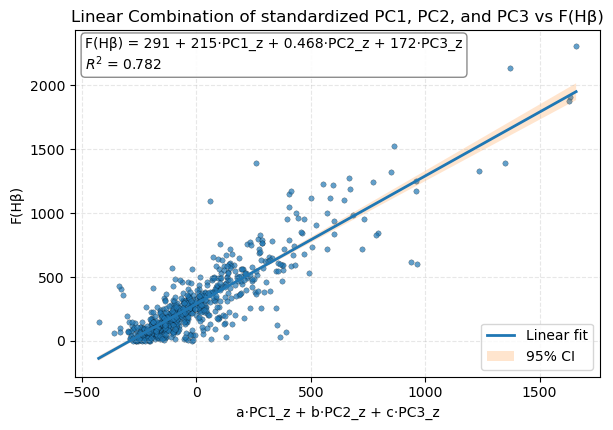

In [ ]:
# Multivariate: F(Hβ) ~ PC1_z + PC2_z + PC3_z, styled like your PC3–ratio plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

DF    = hb               # DataFrame with 'PC1','PC2','PC3' and Hβ flux
Y_COL = 'F_Hb_net'                # or 'F_Hb_net' if that's your target column

# Prepare X (PCs) and y (Hβ)
X = DF.loc[:, ['PC1','PC2','PC3']].apply(pd.to_numeric, errors='coerce').values
y = pd.to_numeric(DF[Y_COL], errors='coerce').values

# Keep only finite rows and (optionally) positive fluxes
mask = np.isfinite(X).all(axis=1) & np.isfinite(y) & (y > 0)
X, y = X[mask], y[mask]
n = y.size
if n < 3:
    raise ValueError("Not enough points after cleaning to fit regression.")

# Standardize PCs (z-scores) the same way sklearn does (ddof=0)
scaler = StandardScaler()
Xz = scaler.fit_transform(X)   # columns ≈ N(0,1)

lin = LinearRegression().fit(Xz, y)
coefs = lin.coef_              # [a, b, c] on (PC1_z, PC2_z, PC3_z)
intercept = lin.intercept_

a1, a2, a3 = coefs
# Linear predictor on x-axis for a clean 2D plot:
x_pred = Xz @ coefs # = a1*PC1_z + a2*PC2_z + a3*PC3_z

# For CI/line, fit y vs x_pred (should give slope ~1 and intercept ~intercept)
lin2 = stats.linregress(x_pred, y)
m_fit, b_fit, r2 = lin2.slope, lin2.intercept, lin2.rvalue**2

# Predicted line and 95% CI for mean response
x_line = np.linspace(x_pred.min(), x_pred.max(), 300)
y_line = m_fit * x_line + b_fit

y_hat = m_fit * x_pred + b_fit
s_err = np.sqrt(np.sum((y - y_hat)**2) / (n - 2))
x_mean = x_pred.mean()
Sxx = np.sum((x_pred - x_mean)**2)
if Sxx == 0:
    raise ValueError("Linear predictor has zero variance; cannot plot regression line.")
t_val = stats.t.ppf(1 - 0.025, df=n - 2)
se_mean = s_err * np.sqrt((1/n) + ((x_line - x_mean)**2 / Sxx))
ci_upper = y_line + t_val * se_mean
ci_lower = y_line - t_val * se_mean

# Labels
x_label = "a·PC1_z + b·PC2_z + c·PC3_z"
y_label = "F(Hβ)"

# Plot — same style as your reference figure
plt.figure(figsize=(6.2, 4.4))
plt.scatter(x_pred, y, s=15, alpha=0.7, edgecolor='k', lw=0.2)
plt.plot(x_line, y_line, lw=2, label='Linear fit')
plt.fill_between(x_line, ci_lower, ci_upper, alpha=0.2, label='95% CI')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Linear Combination of standardized PC1, PC2, and PC3 vs F(Hβ)')
plt.grid(ls='--', alpha=0.3)

# --- Equation box: true multivariate coefficients on standardized PCs ---------
def fmt_signed(v):  # pretty +/− and 3 sig figs
    return f"{v:+.3g}".replace("+", "+ ").replace("-", "- ")

eq = (
    f"F(Hβ) = {intercept:.3g} "
    f"{fmt_signed(a1)}·PC1_z "
    f"{fmt_signed(a2)}·PC2_z "
    f"{fmt_signed(a3)}·PC3_z\n"
    f"$R^2$ = {r2:.3f}"
)
plt.annotate(eq, xy=(0.02, 0.98), xycoords='axes fraction',
             va='top', ha='left',
             bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray', alpha=0.9))

plt.legend()
plt.tight_layout()
plt.show()


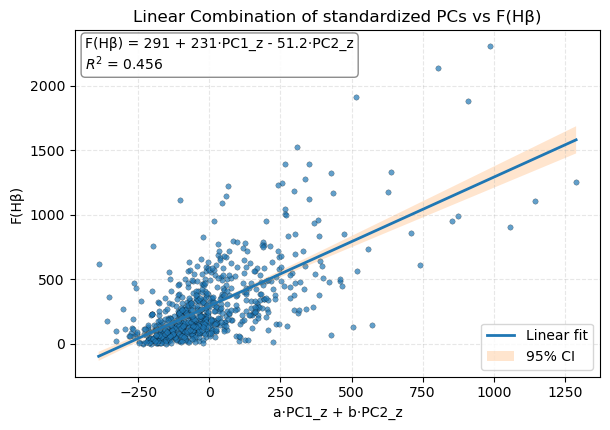

In [ ]:
# Multivariate: F(Hβ) ~ PC1_z + PC2_z + PC3_z, styled like your PC3–ratio plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

DF    = hb               # DataFrame with 'PC1','PC2','PC3' and Hβ flux
Y_COL = 'F_Hb_net'                # or 'F_Hb_net' if that's your target column

# Prepare X (PCs) and y (Hβ)
X = DF.loc[:, ['PC1','PC2']].apply(pd.to_numeric, errors='coerce').values
y = pd.to_numeric(DF[Y_COL], errors='coerce').values

# Keep only finite rows and (optionally) positive fluxes
mask = np.isfinite(X).all(axis=1) & np.isfinite(y) & (y > 0)
X, y = X[mask], y[mask]
n = y.size

# ---- Standardize PCs (z-scores) the same way sklearn does (ddof=0) ----------
scaler = StandardScaler()
Xz = scaler.fit_transform(X)   # columns ≈ N(0,1)

# ---- Multivariable linear regression ----------------------------------------
lin = LinearRegression().fit(Xz, y)
coefs = lin.coef_              # [a, b, c] on (PC1_z, PC2_z, PC3_z)
intercept = lin.intercept_

a1, a2 = coefs
# Linear predictor on x-axis for a clean 2D plot:
x_pred = Xz @ coefs            # = a1*PC1_z + a2*PC2_z + a3*PC3_z

# For CI/line, fit y vs x_pred (should give slope ~1 and intercept ~intercept)
lin2 = stats.linregress(x_pred, y)
m_fit, b_fit, r2 = lin2.slope, lin2.intercept, lin2.rvalue**2

# Predicted line and 95% CI for mean response
x_line = np.linspace(x_pred.min(), x_pred.max(), 300)
y_line = m_fit * x_line + b_fit

y_hat = m_fit * x_pred + b_fit
s_err = np.sqrt(np.sum((y - y_hat)**2) / (n - 2))
x_mean = x_pred.mean()
Sxx = np.sum((x_pred - x_mean)**2)

t_val = stats.t.ppf(1 - 0.025, df=n - 2)
se_mean = s_err * np.sqrt((1/n) + ((x_line - x_mean)**2 / Sxx))
ci_upper = y_line + t_val * se_mean
ci_lower = y_line - t_val * se_mean

# Labels
x_label = "a·PC1_z + b·PC2_z"
y_label = "F(Hβ)"

# Plot — same style as your reference figure
plt.figure(figsize=(6.2, 4.4))
plt.scatter(x_pred, y, s=15, alpha=0.7, edgecolor='k', lw=0.2)
plt.plot(x_line, y_line, lw=2, label='Linear fit')
plt.fill_between(x_line, ci_lower, ci_upper, alpha=0.2, label='95% CI')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Linear Combination of standardized PC1 and PC2 vs F(Hβ)')
plt.grid(ls='--', alpha=0.3)

# --- Equation box: true multivariate coefficients on standardized PCs ---------
def fmt_signed(v):  # pretty +/− and 3 sig figs
    return f"{v:+.3g}".replace("+", "+ ").replace("-", "- ")

eq = (
    f"F(Hβ) = {intercept:.3g} "
    f"{fmt_signed(a1)}·PC1_z "
    f"{fmt_signed(a2)}·PC2_z\n"
    f"$R^2$ = {r2:.3f}"
)
plt.annotate(eq, xy=(0.02, 0.98), xycoords='axes fraction',
             va='top', ha='left',
             bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray', alpha=0.9))

plt.legend()
plt.tight_layout()
plt.show()


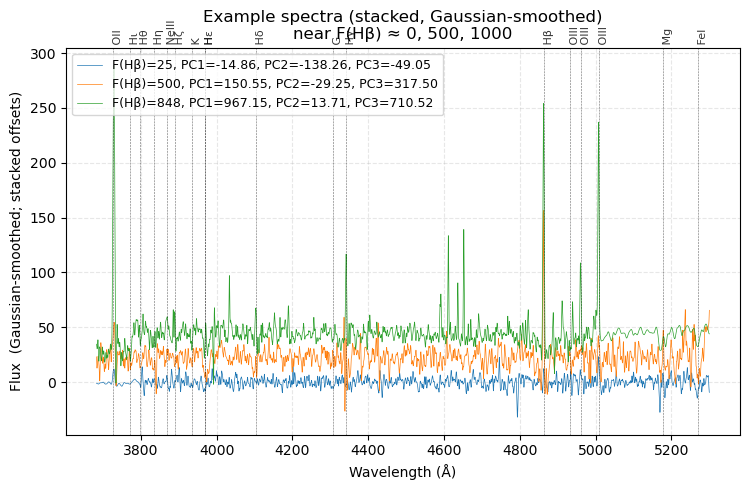

,PC1,PC2,PC3,F_Hbeta,idx
457,-14.862626,-138.262828,-49.049490,24.896592,1516
407,150.547762,-29.249741,317.501844,499.966222,1361
95,967.150163,13.705328,710.517198,847.714784,346


In [ ]:
# Stacked example spectra (Gaussian-smoothed) with element lines 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try scipy's gaussian_filter1d; fall back to manual convolution if unavailable
try:
    from scipy.ndimage import gaussian_filter1d
    _HAS_SCI = True
except Exception:
    _HAS_SCI = False

DF    = hb     # DataFrame that has 'PC1','PC2','PC3' and F(Hβ)
Y_COL = 'F_Hb_net'      # change to 'F_Hb_net' if that's your Hβ column name

# Smoothing width (in pixels along the wavelength grid)
SMOOTH_SIGMA_PIX = 3.0

# Element lines (wavelength Å -> label)
elem_lines = {
    '3727.0921' : 'OII',
    '3771'      : 'Hι',
    '3798'      : 'Hθ',
    '3835.40'   : 'Hη',
    '3869'      : 'NeIII',
    '3889.06'   : 'Hζ',
    '3970.08'   : 'Hε',
    '4102.89'   : 'Hδ',
    '4341.68'   : 'Hγ',
    '4862.68'   : 'Hβ',
    '4932.603'  : 'OIII',
    '4960.295'  : 'OIII',
    '5008.240'  : 'OIII',
    '3934.777'  : 'K',
    '3969.588'  : 'H',
    '4305.61'   : 'G',
    '5176.7'    : 'Mg',
    '5269.5'    : 'FeI',
}

# Resolve flux matrix and wavelength grid already defined earlier in the notebook
_env = globals()
def _resolve(name_list, what):
    for nm in name_list:
        if nm in _env:
            return _env[nm]
    raise NameError(f"Could not find {what}. Expected one of: {', '.join(name_list)}")

M = _resolve(['flux_matrix', 'X', 'matrix', 'flux'], 'flux matrix (2D array [n_spectra, n_lambda])')
lam = _resolve(['wavelengths', 'lam_rest', 'lambda_rest', 'lam', 'wave'], 'wavelength grid (1D array)')

# Find a column that maps DF rows to matrix rows (if present)
ROW_KEY = None
for k in ('idx', 'row_index', 'row', 'matrix_row'):
    if k in DF.columns:
        ROW_KEY = k
        break

# ------------------------ choose 3 example spectra ----------------------------
targets = [25.0, 500.0, 850.0]

df = DF.copy()
df[Y_COL] = pd.to_numeric(df[Y_COL], errors='coerce')
df = df[df[Y_COL].notna()]

chosen_idx = []
for t in targets:
    remaining = df.loc[~df.index.isin(chosen_idx)]
    if remaining.empty:
        break
    pick = (remaining[Y_COL] - t).abs().idxmin()
    chosen_idx.append(pick)

ex = DF.loc[chosen_idx, ['PC1','PC2','PC3', Y_COL]].copy()
if ROW_KEY is not None:
    ex[ROW_KEY] = DF.loc[chosen_idx, ROW_KEY].astype(int)
else:
    # fall back: assume DF's index aligns with the matrix row
    ex['matrix_row'] = pd.Index(chosen_idx).astype(int)
    ROW_KEY = 'matrix_row'

# ------------------------ fetch + smooth the spectra --------------------------
def _gauss1d(y, sigma_pix):
    if _HAS_SCI:
        return gaussian_filter1d(y, sigma=sigma_pix, mode='nearest', truncate=4.0)
    # Manual Gaussian kernel if SciPy isn't available
    sigma_pix = float(sigma_pix)
    rad = int(np.ceil(4.0 * sigma_pix))
    xk = np.arange(-rad, rad+1, dtype=float)
    ker = np.exp(-(xk**2) / (2.0 * sigma_pix**2))
    ker /= ker.sum()
    return np.convolve(y, ker, mode='same')

specs_sm = []
for ridx in ex[ROW_KEY].astype(int).tolist():
    y0 = np.asarray(M[ridx, :], dtype=float)
    specs_sm.append(_gauss1d(y0, SMOOTH_SIGMA_PIX))

# -------------------- vertical offsets so traces don't overlap ----------------
def robust_span(y):
    p5, p95 = np.nanpercentile(y, [5, 95])
    return float(p95 - p5)

offset_step = 0.8 * np.nanmedian([robust_span(s) for s in specs_sm]) if len(specs_sm) else 0.0
offsets = np.arange(len(specs_sm)) * offset_step

# ---------------------------------- plot --------------------------------------
plt.figure(figsize=(7.6, 5.0))

# Plot stacked spectra
for i, (row, y_sm) in enumerate(zip(ex.itertuples(index=False), specs_sm)):
    y_plot = y_sm + offsets[i]
    lab = (f"F(Hβ)={getattr(row, Y_COL):.0f}, "
           f"PC1={getattr(row, 'PC1'):.2f}, "
           f"PC2={getattr(row, 'PC2'):.2f}, "
           f"PC3={getattr(row, 'PC3'):.2f}")
    plt.plot(lam, y_plot, lw=0.5, label=lab)

# Determine y-range for vertical lines
ymin, ymax = plt.gca().get_ylim()
y_top = ymax
y_bottom = ymin

# Overlay element lines (only those within the wavelength window)
for wl_str, label in elem_lines.items():
    try:
        wl = float(wl_str)
    except Exception:
        continue
    if lam.min() <= wl <= lam.max():
        plt.axvline(wl, ls='--', lw=0.4, alpha=0.6, color='k')
        # place label at the top; rotate for readability
        plt.text(wl, y_top, f" {label}", rotation=90, va='bottom', ha='left',
                 fontsize=8, alpha=0.8)

plt.xlabel("Wavelength (Å)")
plt.ylabel("Flux  (Gaussian-smoothed; stacked offsets)")
plt.title("Example spectra (stacked, Gaussian-smoothed)\nnear F(Hβ) ≈ 0, 500, 1000")
plt.grid(ls="--", alpha=0.3)
plt.legend(loc="upper left", fontsize=9, frameon=True)
plt.tight_layout()
plt.show()

# Show the exact rows chosen (helpful for captions / reproducibility)
display(ex.rename(columns={Y_COL: 'F_Hbeta'}))
